# Predict survival on the Titanic using probabilistic models

## Load data

In [5]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [6]:
train_df = pd.read_csv('data/titanic/train.csv')
test_df = pd.read_csv('data/titanic/test.csv')

In [7]:
train_df['data'] = 'train'
test_df['data'] = 'test'
data_df = pd.concat([train_df, test_df])

In [8]:
data_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,data
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train


**Columns**

```
VARIABLE DESCRIPTIONS:
survival        Survival
            (0 = No; 1 = Yes)
pclass          Passenger Class
            (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
            (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.
```

## Process data

In [86]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize

In [149]:
vec = DictVectorizer(sparse=False)
# feature_names = ['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
feature_names = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
raw_features = data_df[feature_names].to_dict('records')

for r in raw_features:
#     if isinstance(r['Cabin'], str):
#         r['Cabin'] = r['Cabin'][0] # collapse cabin # to the first letter only
    r['0_intercept'] = 1

vec.fit(raw_features)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

In [150]:
vec.get_feature_names()

['0_intercept',
 'Age',
 'Embarked',
 'Embarked=C',
 'Embarked=Q',
 'Embarked=S',
 'Fare',
 'Parch',
 'Pclass',
 'Sex=female',
 'Sex=male',
 'SibSp']

In [151]:
mask = (data_df['data'] == 'train').values
X = vec.transform(data_df[feature_names].to_dict('records'))
X = np.nan_to_num(X)
X_normed = normalize(X, norm='l2', axis=0)

X_train = X_normed[mask]
X_test = X_normed[~mask]
Y = data_df['Survived'][mask].values

assert Y.shape[0] == X_train.shape[0]

In [152]:
Y = Y.astype(int)

## Normal regression

In [132]:
import pystan as ps

In [133]:
def check_mcmc_conversion(fit, param_names):
    # extract samples for each chain and param
    samples = fit.extract(permuted=False, inc_warmup=False)
    n_samples, n_chains, n_params = samples.shape
    
    n_params = len(param_names)
    f, axs = plt.subplots(1,n_params,figsize=(5*n_params,3))
    
    if n_params == 1:
        axs = [axs]
    
    for param, ax in zip(param_names, axs):
        for chain_id in range(n_chains):
            smpl = samples[:, chain_id, fit.flatnames.index(param)]
            label = 'chain %d' % chain_id
            sns.kdeplot(smpl, label=label, ax=ax)
        ax.set_title(param)
        ax.legend()
    plt.show()

In [134]:
# http://datascienceplus.com/bayesian-regression-with-stan-part-1-normal-regression/

In [40]:
normal_regression_code = """
data {
    int n;                //the number of observations
    int n_t;              //the size of the X_test matrix
    int k;                //the number of columns in the model matrix
    real y[n];            //the response
    matrix[n,k] X;        //the model matrix
    matrix[n_t,k] X_test;  //the matrix for the predicted values
}
parameters {
    vector[k] W;       //the regression parameters
    real sigma;        //the standard deviation
}
transformed parameters {
    vector[n] linpred;
    linpred = X*W;
}
model {  
    W[1] ~ cauchy(0,10);

    for(i in 2:k)
        W[i] ~ cauchy(0,2.5);
  
    y ~ normal(linpred, sigma);
}
generated quantities {
    vector[n_t] y_pred;
    y_pred = X_test*W; //the y values predicted by the model
}
"""

In [135]:
data = {
    'n': X_train.shape[0],
    'n_t': X_test.shape[0],
    'k': X_train.shape[1],
    'y': Y,
    'X': X_train,
    'X_test': X_test
}

fit_linear = ps.stan(model_code=normal_regression_code, data=data, iter=1000, warmup=100, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb4b5be141a46cbf208681f658b8dbfe NOW.


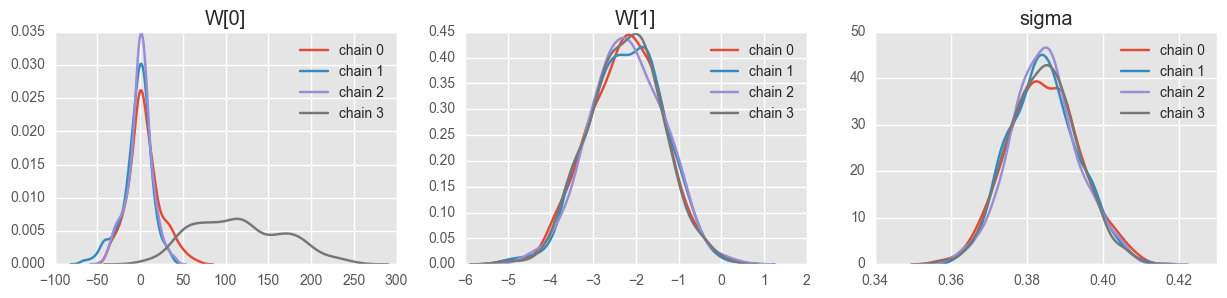

In [136]:
check_mcmc_conversion(fit_linear, ['W[0]', 'W[1]', 'sigma'])

## Logistic Regression

In [159]:
logistic_regression_code = """
data {
    int n;                   //the number of observations
    int n_t;                 //the size of the X_test matrix
    int k;                   //the number of columns in the model matrix
    int y[n];                //the response
    matrix[n,k] X;           //the model matrix
    matrix[n_t,k] X_test;    //the matrix for the predicted values
}
parameters {
    vector[k] W;             //the regression parameters
}
transformed parameters {
    vector[n] lg;
    vector[n] linpred;
    
    linpred = X*W;
    for(i in 1:n)
        lg[i] = 1 / (1 + exp(-linpred[i]));
}
model {  
    W ~ normal(0,10);
    y ~ bernoulli(lg);
}
generated quantities {
    vector[n_t] y_pred;
    vector[n_t] linpred_t;

    linpred_t = X_test*W;
    for(i in 1:k) {
        y_pred[i] = bernoulli_rng(inv_logit(linpred_t[i]));
    }
}
"""

In [160]:
data = {
    'n': X_train.shape[0],
    'n_t': X_test.shape[0],
    'k': X_train.shape[1],
    'y': Y,
    'X': X_train,
    'X_test': X_test
}

fit_logistic = ps.stan(model_code=logistic_regression_code, data=data, iter=500, warmup=200, chains=4,
                      algorithm='NUTS')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43c0e521104e4782d96aeea93147827d NOW.


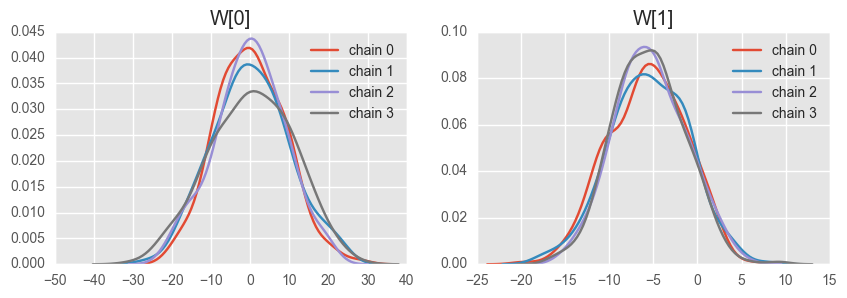

In [162]:
check_mcmc_conversion(fit_logistic, ['W[0]', 'W[1]'])